# Asthma and Smoke Estimate Analysis

In this Notebook, we will explore the following questions for Green Bay, Wisconsin:

- What is the relationship between asthma metrics (emergency visits, hospitalizations) and smoke estimates?
- What does this mean for the people of Green Bay, Wisconsin?

We build off the smoke estimate created in the `common_analysis.ipynb` Notebook and bring in asthma data for Brown County, WI from the [Environmental Public Health Tracking: Asthma Data dashboard](https://www.dhs.wisconsin.gov/epht/asthma.htm) provided by the Wisconsin Department of Health Services. As outlined in the [Wisconsin.Gov Privacy Policy](https://www.wisconsin.gov/Pages/Policies.aspx), material on the website is available for noncommercial use by the general public under fair use guidelines. The data itself follows HIPAA guidelines by retaining the data anonymously. Counts less than five but more than zero are suppressed to protect confidentiality.

This notebook is available under the MIT license.

Start by importing necessary Python modules.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

## Data
### Asthma Data
The following datasets are from the [Environmental Public Health Tracking: Asthma Data dashboard](https://www.dhs.wisconsin.gov/epht/asthma.htm).

The datasets can be acquired by selecting "County" under the "Select a Geography" section on the top left-hand side of the dashboard, and then selecting "Brown" from the drop-down of counties at the top left corner of the line graph under the map. To download the source data, click on the square with a downwards arrow at the bottom right of the dashboard. Select "Crosstab" from the list, and select "County Trend" from the list of sheets available to download. Select the csv format at the bottom of the prompt and click "Download".

### Metric Definitions
We use age-adjusted rates of asthma-related hospitalizations and emergency room visits per 10,000 people in Brown County, Wisconsin from the year 2000 through 2023*. The dataset also includes the overall age-adjusted rates of asthma-related hospitalizations and emergency room visits in the state of Wisconsin for each year to facilitate comparisons between Brown County and the State.

Note that emergency department visits include those that result in hospitalization, meaning that there will be some overlap between counts in the emergency visit and hospitalization datasets.

Age-adjusted rates are used instead of raw counts and crude rates to facilitate comparisons and account for the possibility that emergency department visits and hospitalizations for asthma may be more frequent among different age groups. The denominator for the rates comes from the population of interest – for example, the rate for Brown County looks at the Brown County population only, while the overall Wisconsin rates will take all Wisconsin residents into account. Age-adjustment is calculated using the 2000 U.S. standard population published by the National Center for Health Statistics (NCHS) using projections from the U.S. Census. 

### Data Cleaning
The datasets were first cleaned in Excel to retain just the county and state age-adjusted rates for each year by simply removing the unncessary columns. We do this by deleting all the columns that either do not contain a year or the word `rate` in the row name.

The cleaned files we used in this analysis are available in the `asthma_data` folder in the repository.

We will then need to transpose and clean the data further before we can use it in our analyses.

*Emergency visit rates are available from 2002-2023, and hospitalization rates are available from 2000-2022.

Start by loading in the emergency visits data.

In [2]:
# load emergency visits data
emergency_visits_csv = pd.read_csv("asthma_data/Brown County Asthma Emergency Visit Rates.csv")
emergency_visits_csv.head()

,Year,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,County rate,43.40,46.60,46.20,39.90,44.10,39.80,39.00,43.90,42.20,...,39.10,38.50,40.70,37.20,36.10,33.00,22.70,22.90,28.00,24.3
1,State rate,48.21,50.27,46.32,47.23,43.99,44.32,44.43,46.01,40.75,...,39.49,43.64,38.44,38.01,36.67,35.42,22.87,27.32,28.47,30.9
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see that as a result of our preliminary cleaning in Excel, we have a lot of NaN values that need to be removed. We do that below, then melt the data to get the desired format, and then create a county copy and a state copy of the data.

In [3]:
# remove nulls
emergency_visits_csv.dropna(inplace=True)
# melt the data
emergency_visits_melt = pd.melt(emergency_visits_csv, id_vars=['Year'], value_name='Emergency Rate').copy()
emergency_visits_melt = emergency_visits_melt.rename(columns={'Year': 'Rate Type', 'variable': 'Year'})
emergency_visits_melt = emergency_visits_melt[['Year', 'Rate Type', 'Emergency Rate']]
emergency_visits_melt['Year'] = pd.to_numeric(emergency_visits_melt['Year'])
# filter to county rates
emergency_visits = emergency_visits_melt[emergency_visits_melt['Rate Type'] == 'County rate'].copy()
emergency_visits.reset_index(drop=True)
print(emergency_visits.head())
# create a state level copy of the data
emergency_visits_state = emergency_visits_melt[emergency_visits_melt['Rate Type'] == 'State rate'].copy()
emergency_visits_state.reset_index(drop=True)
print(emergency_visits_state.head())

   Year    Rate Type  Emergency Rate
0  2002  County rate            43.4
2  2003  County rate            46.6
4  2004  County rate            46.2
6  2005  County rate            39.9
8  2006  County rate            44.1
   Year   Rate Type  Emergency Rate
1  2002  State rate           48.21
3  2003  State rate           50.27
5  2004  State rate           46.32
7  2005  State rate           47.23
9  2006  State rate           43.99


Let's load the hospitalization data next and perform the same procedure.

In [4]:
# load hospitalizations data
hospitalizations_csv = pd.read_csv("asthma_data/Brown County Asthma Hospitalization Rates.csv")
hospitalizations_csv.head()

,Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,County rate,9.10,8.80,8.80,10.50,8.40,7.30,8.50,7.40,6.5,...,5.1,4.40,3.40,3.10,3.10,3.50,3.30,1.40,1.90,3.00
1,State rate,10.72,10.23,9.73,11.26,9.82,10.17,9.13,8.88,9.4,...,8.4,8.73,6.64,3.51,3.58,3.59,2.97,1.62,2.13,2.43
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# remove nulls
hospitalizations_csv.dropna(inplace=True)
# melt the data
hospitalizations_melt = pd.melt(hospitalizations_csv, id_vars=['Year'], value_name='Hospitalization Rate').copy()
hospitalizations_melt = hospitalizations_melt.rename(columns={'Year': 'Rate Type', 'variable': 'Year'})
hospitalizations_melt = hospitalizations_melt[['Year', 'Rate Type', 'Hospitalization Rate']]
hospitalizations_melt['Year'] = pd.to_numeric(hospitalizations_melt['Year'])
# filter to county rates
hospitalizations = hospitalizations_melt[hospitalizations_melt['Rate Type'] == 'County rate'].copy()
hospitalizations.reset_index(drop=True)
print(hospitalizations.head())
# create a state level copy of the data
hospitalizations_state = hospitalizations_melt[hospitalizations_melt['Rate Type'] == 'State rate'].copy()
hospitalizations_state.reset_index(drop=True)
print(hospitalizations_state.head())

   Year    Rate Type  Hospitalization Rate
0  2000  County rate                   9.1
2  2001  County rate                   8.8
4  2002  County rate                   8.8
6  2003  County rate                  10.5
8  2004  County rate                   8.4
   Year   Rate Type  Hospitalization Rate
1  2000  State rate                 10.72
3  2001  State rate                 10.23
5  2002  State rate                  9.73
7  2003  State rate                 11.26
9  2004  State rate                  9.82


### Smoke Estimate Data
Here we import the smoke estimates and predictions from the intermediate csv files created in the `common_analysis.ipynb` Notebook. These files can also be found in the `intermediate_data` folder of the repository. We will use these later to perform analyses with the asthma data.

In [6]:
# import smoke estimates
smoke_estimates = pd.read_csv('intermediate_data/smoke_estimates.csv')
# remove the redundant index column
smoke_estimates = smoke_estimates[['Fire_Year', 'Smoke_Estimate']].rename(columns={'Fire_Year': 'Year'})
smoke_estimates.head()

,Year,Smoke_Estimate
0,1964,0.020477
1,1965,0.383046
2,1966,0.004412
3,1967,0.110100
4,1968,0.009459


In [7]:
# import smoke estimate predictions from 2025-2050
smoke_predictions = pd.read_csv('intermediate_data/smoke_predictions.csv')
# remove the redundant index column
smoke_predictions = smoke_predictions[['Year', 'Forecast', 'Upper CI', 'Lower CI']]
smoke_predictions.head()

,Year,Forecast,Upper CI,Lower CI
0,2025,27.956011,45.155746,10.991589
1,2026,27.845015,46.242911,10.212320
2,2027,29.054728,46.273956,11.016964
3,2028,29.850270,48.546989,10.905273
4,2029,29.749102,51.049339,10.630108


## Exploratory Analysis

In this section we explore the asthma-related metrics for Brown County, WI. We start by looking at each metric's trend over time, and then compare emergency visit rates to hospitalization rates.

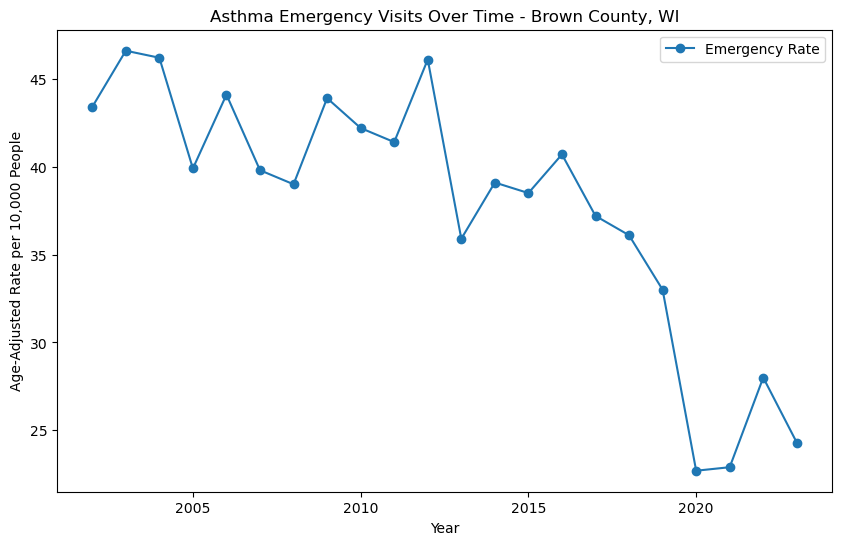

In [8]:
# plot emergency visits over time
emergency_visits.plot(x='Year', y='Emergency Rate', kind='line', marker='o',
                      title='Asthma Emergency Visits Over Time - Brown County, WI', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Age-Adjusted Rate per 10,000 People')
plt.show()

We see that emergency visit rates for asthma in Brown County have been decreasing over time, with a large drop in 2020 likely due to COVID-19. Let's look at hospitalization rate trends next.

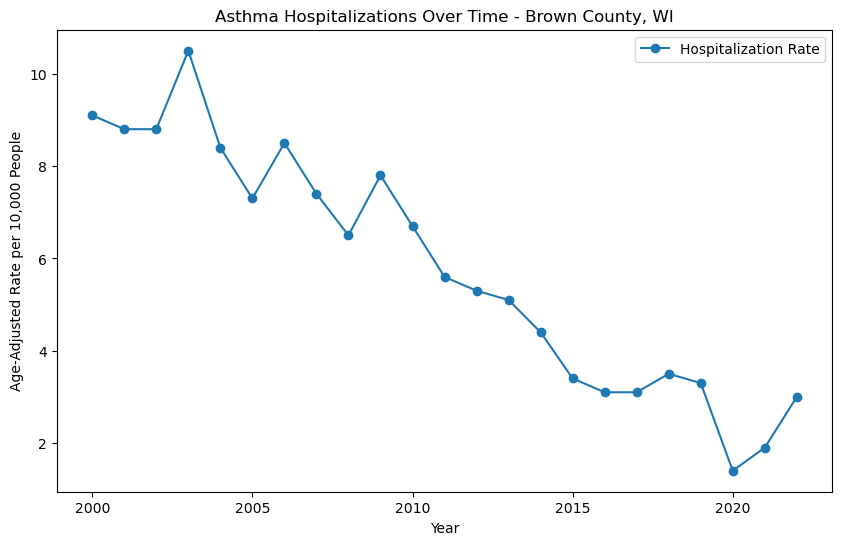

In [9]:
# plot hospitalizations over time
hospitalizations.plot(x='Year', y='Hospitalization Rate', kind='line', marker='o',
                      title='Asthma Hospitalizations Over Time - Brown County, WI', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Age-Adjusted Rate per 10,000 People')
plt.show()

We see that hospitalization rates for asthma in Brown County have also been decreasing over time, with a drop in 2020 likely for similar reasons as the emergency visits.
Let's look at these rates on the same plot next for a more direct comparison. 

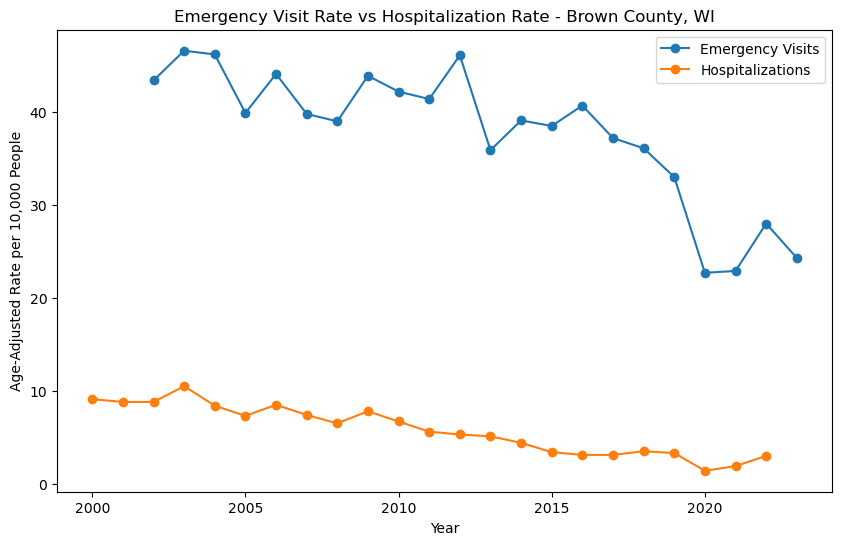

In [10]:
# plot hospitalizations and emergency visits on one graph
plt.figure(figsize=(10, 6))

ax = emergency_visits.plot(x='Year', y='Emergency Rate', kind='line', marker='o', label='Emergency Visits', ax=plt.gca())
hospitalizations.plot(x='Year', y='Hospitalization Rate', kind='line', marker='o', label='Hospitalizations', ax=ax)

plt.title(f"Emergency Visit Rate vs Hospitalization Rate - Brown County, WI")
plt.xlabel('Year')
plt.ylabel('Age-Adjusted Rate per 10,000 People')
plt.legend()

plt.show()

From these three plots, we can see that the asthma emergency visits and hospitalization age-adjusted rates per 10,000 people in Brown County have been generally decreasing from 2000 through 2023. We can also see that the variability in emergency visit rates is much higher than hospitalization rates.

For a point of reference, let's compare these county-level trends to the state-wide rates.

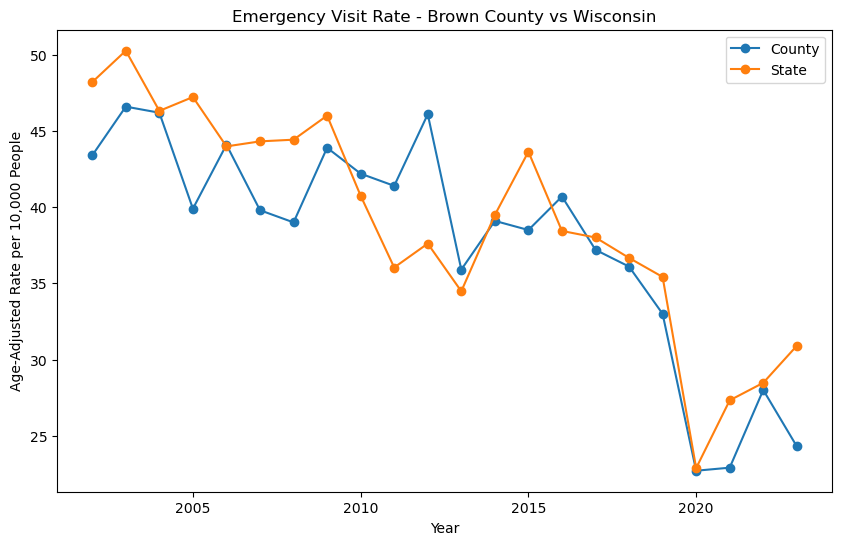

In [11]:
# compare state to county emergency visit rates
plt.figure(figsize=(10, 6))

ax = emergency_visits.plot(x='Year', y='Emergency Rate', kind='line', marker='o', label='County', ax=plt.gca())
emergency_visits_state.plot(x='Year', y='Emergency Rate', kind='line', marker='o', label='State', ax=ax)

plt.title(f"Emergency Visit Rate - Brown County vs Wisconsin")
plt.xlabel('Year')
plt.ylabel('Age-Adjusted Rate per 10,000 People')
plt.legend()

plt.show()

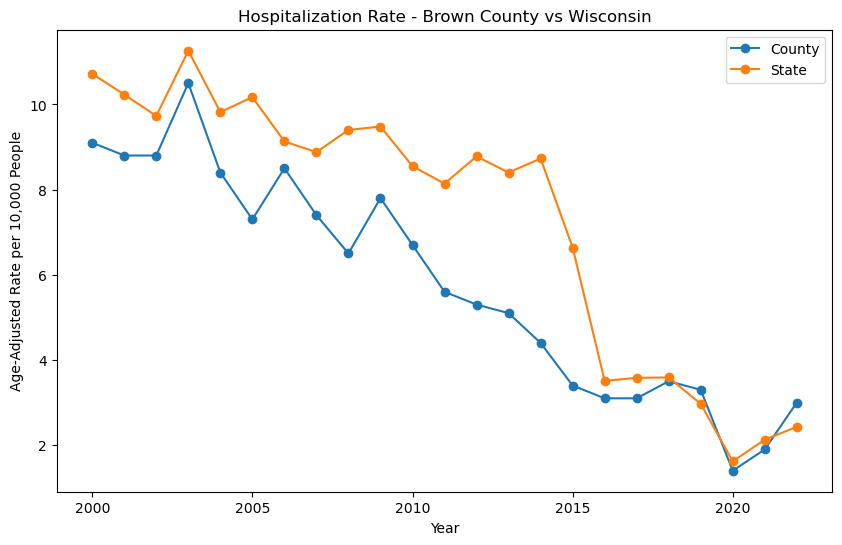

In [12]:
# compare state to county hospitalization rates
plt.figure(figsize=(10, 6))

ax = hospitalizations.plot(x='Year', y='Hospitalization Rate', kind='line', marker='o', label='County', ax=plt.gca())
hospitalizations_state.plot(x='Year', y='Hospitalization Rate', kind='line', marker='o', label='State', ax=ax)

plt.title(f"Hospitalization Rate - Brown County vs Wisconsin")
plt.xlabel('Year')
plt.ylabel('Age-Adjusted Rate per 10,000 People')
plt.legend()

plt.show()

From the above plots, we can see that the hospitalization rate for Brown County is generally lower than the statewide rate until 2018. The emergency visit rate for Brown County is noticeably higher than the statewide rate in 2012. Other than that year, the emergency visit rate for Brown County is generally similar or lower than the statewide rate.

## Smoke Estimate Analysis

In this section we analyze the correlation between asthma metrics (emergency room visit rates and hospitalization rates) and smoke estimates for Green Bay, WI. With a lack of more granular data available, since Green Bay is the largest city in the county we assume the county-level metrics can serve as a proxy for the city's metrics.

We start by looking at the correlation between the two asthma metrics and the smoke estimates. Since the emergency room visit rates and hospitalization rates are only available from 2002-2023 and 2000-2022, respectively, and smoke estimates are available from 1964-2020, we will focus on data from 2002-2020 where all metrics are available.

Let's start by creating a combinied dataset, merging on year.

In [13]:
# start by creating a combined dataset
# filter both datasets to the overlapping years (2002–2020)
hospitalizations_filtered = hospitalizations[hospitalizations['Year'] <= 2020]
hospitalizations_filtered = hospitalizations_filtered[['Year', 'Hospitalization Rate']]
emergencyvisits_filtered = emergency_visits[emergency_visits['Year'] <= 2020]
emergencyvisits_filtered = emergencyvisits_filtered[['Year', 'Emergency Rate']]
smoke_filtered = smoke_estimates[smoke_estimates['Year'] >= 2000]

# merge on year
merged_data = pd.merge(hospitalizations_filtered, emergencyvisits_filtered, on='Year')
merged_data = pd.merge(merged_data, smoke_filtered, on='Year')
merged_data.set_index('Year', inplace=True)
print(merged_data.head())

      Hospitalization Rate  Emergency Rate  Smoke_Estimate
Year                                                      
2002                   8.8            43.4        6.238580
2003                  10.5            46.6       13.723999
2004                   8.4            46.2        6.856390
2005                   7.3            39.9       10.362748
2006                   8.5            44.1       16.093096


Next, we plot the three metrics, asthma emergency visit rates, asthma hospitalization rates, and smoke estimates, on one graph for a visual comparison.

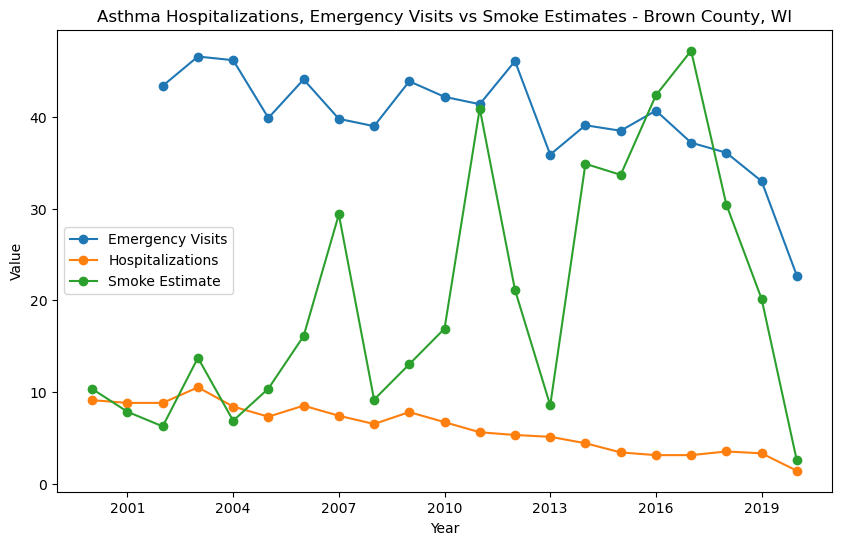

In [14]:
# visualize the three metrics
plt.figure(figsize=(10, 6))

ax1 = emergencyvisits_filtered.plot(x='Year', y='Emergency Rate', kind='line', marker='o', label='Emergency Visits', ax=plt.gca())
ax2 = hospitalizations_filtered.plot(x='Year', y='Hospitalization Rate', kind='line', marker='o', label='Hospitalizations', ax=ax1)
smoke_filtered.plot(x='Year', y='Smoke_Estimate', kind='line', marker='o', label='Smoke Estimate', ax=ax2)

plt.title(f"Asthma Hospitalizations, Emergency Visits vs Smoke Estimates - Brown County, WI")
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

The first thing we notice here is the large variability in smoke estimates over time, where it looks like an almost seasonal pattern. The smoke estimate very obviously behaves differently from the two asthma age-adjusted rates.

Next we calculate pairwise correlation between the three variables.

In [147]:
# calculate correlation
correlation_matrix = merged_data.corr()
print(correlation_matrix)

                      Hospitalization Rate  Emergency Rate  Smoke_Estimate
Hospitalization Rate              1.000000        0.765879       -0.446088
Emergency Rate                    0.765879        1.000000        0.032379
Smoke_Estimate                   -0.446088        0.032379        1.000000


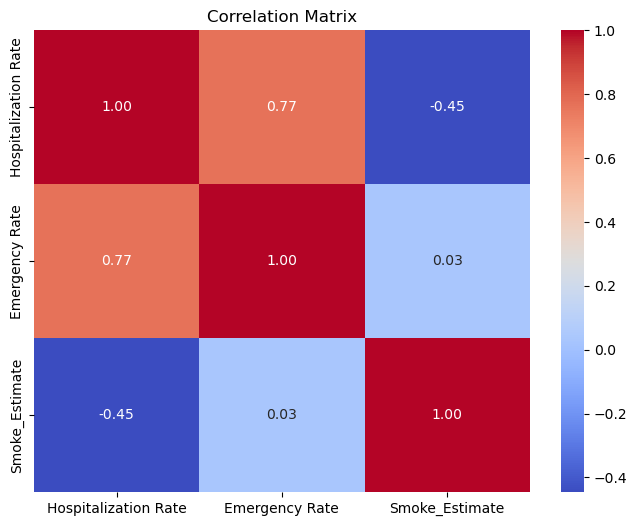

In [148]:
# plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [89]:
# check p-value of correlation
corr, p_value = pearsonr(merged_data['Smoke_Estimate'], merged_data['Hospitalization Rate'])
print(f"Smoke Estimate vs Hospitalization Correlation: {corr}, P-value: {p_value}")

corr, p_value = pearsonr(merged_data['Smoke_Estimate'], merged_data['Emergency Rate'])
print(f"Smoke Estimate vs Emergency Visits Correlation: {corr}, P-value: {p_value}")

corr, p_value = pearsonr(merged_data['Emergency Rate'], merged_data['Hospitalization Rate'])
print(f"Hospitalization Rate vs Emergency Rate Correlation: {corr}, P-value: {p_value}")

Smoke Estimate vs Hospitalization Correlation: -0.44608752525531825, P-value: 0.05557138635635538
Smoke Estimate vs Emergency Visits Correlation: 0.03237867701141622, P-value: 0.8953104870948662
Hospitalization Rate vs Emergency Rate Correlation: 0.7658792831674666, P-value: 0.00013201645230599072


From the check above, we see that besides the correlation between hospitalization rates and emergency room visit rates, the other two pairs do not have a statistically significant correlation. We expect that hospitalization rates and emergency room visit rates are strongly correlated due to the fact that emergency room visits can lead to hospitalizations and the nature of the two metrics. The correlation between the smoke estimate and hospitalization rate has a p-value of about 0.0556, which is very close to the 0.05 cut-off line for statistical significance. We will come back to this later as this may still be of practical significance and worth looking into.

The results above may be a result of a lag effect between smoke and asthma. We explore that possibility with the hospitalization rate below.

We start by computing cross-correlation with lags to identify the lag with the most correlation for lags between -5 to +5 years. 

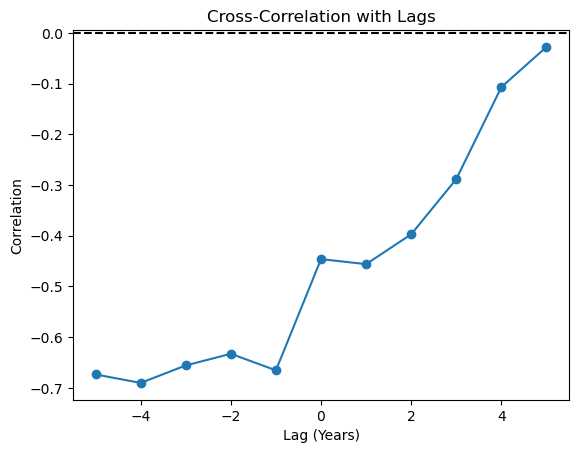

In [ ]:
# try correlations with lag
# compute cross-correlation with lags
smoke = merged_data['Smoke_Estimate']
hospital = merged_data['Hospitalization Rate']

lags = range(-5, 6)  # Test lags from -5 to +5 years
cross_corr = [smoke.corr(hospital.shift(lag)) for lag in lags]

# visualize cross-correlation
plt.plot(lags, cross_corr, marker='o')
plt.title('Cross-Correlation with Lags')
plt.xlabel('Lag (Years)')
plt.ylabel('Correlation')
plt.axhline(0, color='black', linestyle='--')
plt.show()

From the chart above, we see that the largest magnitude correlation occurs at a lag of 4 years (around -0.7). Thus, we will shift the hospitalization data backwards by 4 years and then compute correlation again.

In [137]:
# shift the hospitalization data backward by 4 years
hospitalizations_shifted = hospitalizations.copy()
hospitalizations_shifted = hospitalizations_shifted[['Year','Hospitalization Rate']]
hospitalizations_shifted.set_index('Year', inplace=True)
hospitalizations_shifted = hospitalizations_shifted.shift(-4).dropna()
hospitalizations_shifted
max_year = hospitalizations_shifted.index[-1]
# filter smoke estimates on shifted hospitalization data
smoke_filtered2 = smoke_filtered[smoke_filtered['Year'] <= max_year]
smoke_filtered2.set_index('Year', inplace=True)
# combine into one dataframe
shifted_data = pd.merge(hospitalizations_shifted, smoke_filtered2, left_index=True, right_index=True)
shifted_data

# calculate the correlation again and check p-value
corr, p_value = pearsonr(shifted_data['Smoke_Estimate'], shifted_data['Hospitalization Rate'])
print(f"Correlation between Smoke Estimate and Hospitalization Rate (Lag -4): {corr}, P-value: {p_value}")

Correlation between Smoke Estimate and Hospitalization Rate (Lag -4): -0.7669400661398762, P-value: 0.00012751846575993555


Let's see what the data looks like after we implement the lag.

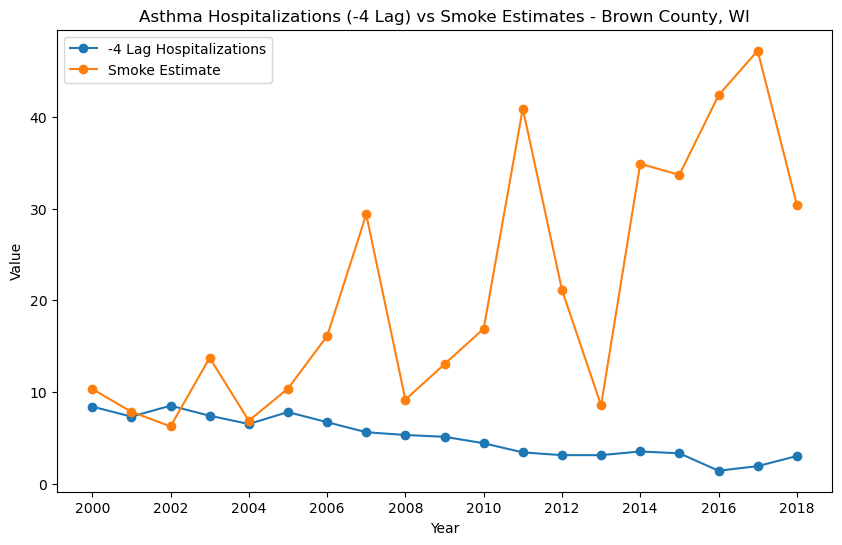

In [143]:
# visualize the lag
# move the year index back into a column
graph_shifted_data = shifted_data.reset_index().rename(columns={'index': 'Year'})
# visualization
plt.figure(figsize=(10, 6))

ax = graph_shifted_data.plot(x='Year', y='Hospitalization Rate', kind='line', marker='o', label='-4 Lag Hospitalizations', ax=plt.gca())
graph_shifted_data.plot(x='Year', y='Smoke_Estimate', kind='line', marker='o', label='Smoke Estimate', ax=ax)

plt.title(f"Asthma Hospitalizations (-4 Lag) vs Smoke Estimates - Brown County, WI")
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

From the correlation computation above, we can see that the shifted hospitalization rates yields a correlation with a statistically significant value. However, we take a step back and think about how logical this implication is. From [brief research online](https://my.clevelandclinic.org/health/diseases/6424-asthma), we see that asthma attacks tend to happen within minutes, hours, or at most days after exposure to a trigger. It doesn't make sense for there to be a 4 year lag between wildfire smoke and asthma hospitalization rates. As such, we should not use this correlation value to draw conclusions.

Instead, we think that the 0.0556 significance value for the correlation between smoke estimates and hospitalization rate is worth moving forward with, as it is close to the cut-off value and perhaps may yield practically significant results, even if it is not necessarily statistically significant.

The -0.45 correlation between smoke estimates and hospitalization rate means there is moderate negative correlation between the two. This means that for higher smoke estimates, we expect lower hospitalization rates. We recognize that this result may be the effect of the limitations of our asthma data and the simplified nature of our smoke estimates. Our annual asthma age-adjusted rates cannot accurately describe the wildfire smoke-related asthma effects, since they include all asthma patients regardless of trigger. The dataset also does not have any distinction for occurences during fire season and occurences outside of fire season. People who are hospitalized for asthma triggered by dust mites or allergies after October 31 and before May 1 should not be included in this wildfire asthma impacts analysis. We acknowledge that this level of detail in healthcare data may not be achieveable in accordance with patient privacy regulations, but it is a potential source of error in this analysis and can lead to impractical results. It can also be noted that the downwards trend in asthma hospitalizations can be a reflection of improved healthcare, or a change in hospital access. As such, we cannot take the -0.45 correlation to mean that more wildfire smoke will create less asthma hospitalizations. Correlation does not mean causation.

As this analysis is ultimately for the people of Green Bay to make better decisions regarding their health, we choose not to create a predictive model using this dataset and smoke estimate. We do not want to publish a predictive model that may interfere with decision-making regarding the well-being of a community. Knowing the complexities of asthma triggers and the intricacies involved in creating a more accurate, representative smoke estimate, the results from this section of the analysis signals that we need to do more investigation to confirm findings and explore possibilities before moving forward. Though we could create a model that predicts a downwards asthma hospitalization trend with smoke estimates as a factor, it does not hold much meaning as we know that these trends are basically independent of each other. Stopping our analysis here is a way to take responsibility for our analysis and ensure accountability for the people this analysis will impact.